<a href="https://colab.research.google.com/github/lpc49/LuxPollen/blob/main/LuxPollen_Data_analysis_with_historical_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pollen in Luxembourg - Data analysis 

In [ ]:
# pandas is a data manipulation and analysis library
import pandas as pd

Loading the cleaned dataset:

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/lpc49/LuxPollen/main/data.csv', index_col=0) 
data

,High Temperature,Low Temperature,Precipitation,Ambrosia,Artemisia,Asteraceae,Alnus,Betula,Ericaceae,Carpinus,Castanea,Quercus,Chenopodium,Cupressaceae,Acer,Fraxinus,Gramineae,Fagus,Juncaceae,Aesculus,Larix,Corylus,Juglans,Umbellifereae,Ulmus,Urtica,Rumex,Populus,Pinaceae,Plantago,Platanus,Salix,Cyperaceae,Filipendula,Sambucus,Tilia,Mean Temperature,Year,Day of year
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1992-01-01,-0.7,-1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.00,1992,1
1992-01-02,-0.6,-2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.65,1992,2
1992-01-03,2.2,-4.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.10,1992,3
1992-01-04,6.9,2.1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.50,1992,4
1992-01-05,7.8,6.4,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.10,1992,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,18.7,12.7,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.70,2021,269
2021-09-27,18.3,10.7,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.50,2021,270
2021-09-28,15.8,9.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.50,2021,271


# Birch pollen with temperature as main covariate

We restrict our attention to pollen from birch (betula in Latin), since it is one of the most allergenic tree pollens in Europe. In the context of this mini-project we also only consider the Mean Temperature as a covariate (not Precipitation or past pollen concentration).

In [ ]:
betula_data = data[['Mean Temperature', 'Betula', 'Year', 'Day of year']]
betula_data

,Mean Temperature,Betula,Year,Day of year
Date,,,,
1992-01-01,-1.00,0.0,1992,1
1992-01-02,-1.65,0.0,1992,2
1992-01-03,-1.10,0.0,1992,3
1992-01-04,4.50,0.0,1992,4
1992-01-05,7.10,0.0,1992,5
...,...,...,...,...
2021-09-26,15.70,0.0,2021,269
2021-09-27,14.50,0.0,2021,270
2021-09-28,12.50,0.0,2021,271


## Visualizing the data

In [ ]:
# plotly, pyplot and seaborn are plotting / visualization libraries
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

We first take a peak at the time series of Birch pollen through the years. We expect it to be very seasonal. As people who are allergic to Birch pollen know very well, we expect heavy concentration peaks a few days per year. 
<br>
Our main goal here is to predict these days based on past temperature data only.

In [ ]:
px.line(betula_data, x=betula_data.index, y='Betula',
        labels={'Betula':"Daily concentration (pollen per m<sup>3</sup>)",
                'x':'Date'
                },
        title='Birch daily pollen concentration')

In order to visualize the data better, we drop the days of the year where the concentration never reaches the allergenic critical threshold as defined in http://www.pollen.lu/index.php?qsPage=allergysteps

In [ ]:
critical_threshold = 10 

In [ ]:
betula_daily_max = betula_data.groupby(by='Day of year').max()

day_min = (betula_daily_max['Betula']>critical_threshold).idxmax()
print('Before day ' + str(day_min) + ' the Birch pollen allergenic threshold is never reached.')

day_max = (betula_daily_max['Betula']>critical_threshold)[::-1].idxmax()
print('After day ' + str(day_max) + ' the Birch pollen allergenic threshold is never reached again until end of year.')

Before day 80 the Birch pollen allergenic threshold is never reached.
After day 151 the Birch pollen allergenic threshold is never reached again until end of year.


We now plot each year in a facet grid representation, as well as the yearly average.

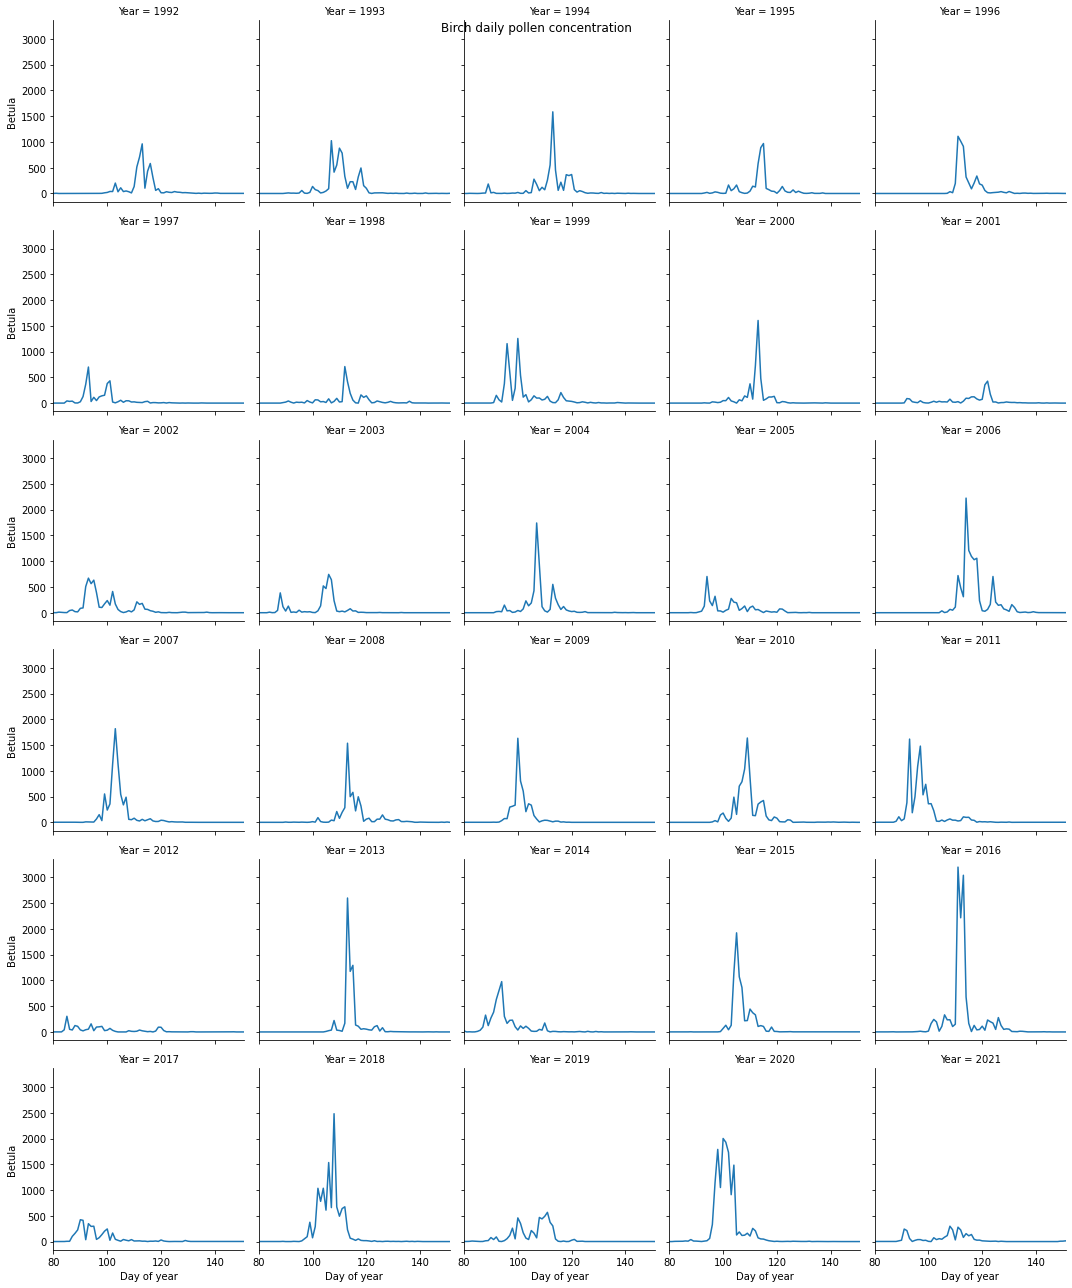

In [ ]:
plot = sns.FacetGrid(betula_data, col='Year', col_wrap=5, height=3)
plot.map(sns.lineplot, 'Day of year', 'Betula')
plot.fig.suptitle('Birch daily pollen concentration')
plt.xlim(day_min, day_max)
plt.show()

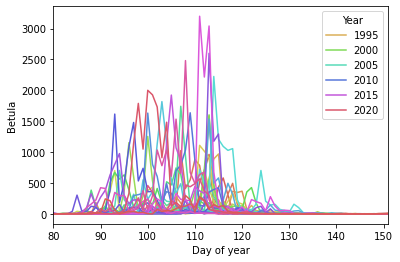

In [ ]:
sns.lineplot(data=betula_data, x='Day of year', y='Betula', hue='Year', palette='hls')
plot.fig.suptitle('Birch pollen concentration')
plt.xlim(day_min, day_max)
plt.show()

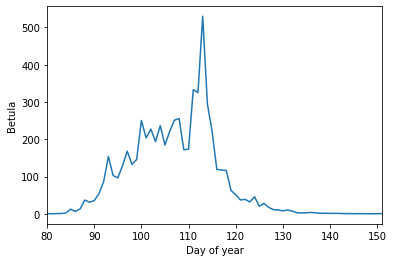

In [ ]:
betula_daily_average = betula_data.groupby(by='Day of year').mean()
sns.lineplot(data=betula_daily_average, x='Day of year', y='Betula')
plot.fig.suptitle('Birch average daily pollen concentration')
plt.xlim(day_min, day_max)
plt.show()

The data being continuous we will use a functional model. As the pollen concentration is zero most of the year we truncate to use only the past 30 days of temperature data to predict the pollen concentration. Finally because of big jumps in the time series we consider the logarithm of the temperature and pollen time series.

## Applying the functional model 

Scikit-fda is a package offering functional data analysis classes, methods and functions. It contains in particular useful functional machine learning models, ability to perform functional principal component analysis, etc.
<br>
See https://fda.readthedocs.io/en/latest

In [ ]:
!pip install scikit-fda

In [ ]:
# skfda is the library for the Scikit-fda package (see above)
import skfda
from skfda import FDataGrid
from skfda.representation.basis import FDataBasis
from skfda.ml.regression import HistoricalLinearRegression

# numpy a library adding support for large/multi-dimensional arrays/matrices with high-level mathematical functions
import numpy as np

# lets us normalize the stochastic processes 
from sklearn.preprocessing import normalize

# lets us split our data into training and testing data
from sklearn.model_selection import train_test_split

# lets us measure the score of our prediction on our testing set
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

 /usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.


Let us define the parameters that we will use. Note that day_min and day_max were defined above: outside of this period the birch pollen in never above the critical allergenic threshold. 

In [ ]:
# for a given day, we will only look at the past 30 days of temperature data 
lag_days = 30

# hence the total relevant period is day_min through day_max, plus 30 days temperature data prior to it.
nb_days = day_max - day_min + lag_days + 1

# grid_points is the range of the temperature and pollen functions
grid_points = np.arange(day_min - lag_days, day_max + 1)

In [ ]:
#restricting the data to the considered time window
betula_observed_data = betula_data[(betula_data['Day of year']>=day_min - lag_days) & (betula_data['Day of year']<=day_max)]

In [ ]:
# year_min is the first year of data (1992)
year_min = int(np.amin(betula_data[['Year']]))

# year_max is the last year of data (2021)
year_max = int(np.amax(betula_data[['Year']]))

nb_years = year_max - year_min + 1

We now define X as the continuous stochastic process of log temperature:
<br>
$X(s) = \log(\text{Temperature}(s) + X_{drift})$
<br> 
where $X_{drift}$ is defined so that the logarithm is well defined.

In [ ]:
X_matrix = betula_observed_data['Mean Temperature'].to_numpy()

# we apply a drift to ensure the logarithm exists even if the temperature gets lower than zero
X_drift = - np.amin(X_matrix) + 1
X_matrix = np.log(X_matrix + X_drift)

# each row of the matrix corresponds to an observation (i.e. a year)
X_matrix = X_matrix.reshape(nb_years, nb_days)

In [ ]:
# defining X as a FDataGrid functional object (inputs are observation matrix and range)
# see also the documentation https://fda.readthedocs.io/en/latest/modules/autosummary/skfda.representation.grid.FDataGrid.html
X = skfda.FDataGrid(X_matrix, grid_points)

We similarly define y as the continuous stochastic process of log pollen concentration:
<br>
$y(t) = \log(\text{Pollen}(t) + 1)$
<br> 
where we added 1 so that the logarithm is well defined.

In [ ]:
y_matrix = betula_observed_data['Betula'].to_numpy()

# we apply a drift of 1 to ensure the logarithm exists even if the measured pollen concentration is zero
y_drift = 1
y_matrix = np.log(y_matrix + y_drift)

# each row of the matrix corresponds to an observation (i.e. a year)
y_matrix = y_matrix.reshape(nb_years, nb_days)

In [ ]:
# defining y as a FDataGrid functional object
y = skfda.FDataGrid(y_matrix, grid_points)

We split X and y into traning and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

We apply the Historical Linear Regression functional model, where past temperature data is used to model present pollen concentration. 
<br>
In other words we assume that $y(t)$ can be explained from $X(s)$ with $t-lag < s < t$ by the linear filtering:

$$E[y(t)|X] = \alpha(t) + \int_{s=t-lag}^t X(s) \beta(s, t) ds$$

See also https://fda.readthedocs.io/en/latest/_modules/skfda/ml/regression/_historical_linear_model.html

In [ ]:
hist = HistoricalLinearRegression(n_intervals=12, lag=lag_days)
hist = hist.fit(X_train, y_train)

In [ ]:
yhat = hist.predict(X_test)

We can now score and visualize the predicted and actual pollen values on the test set, using that 
$\text{Pollen} = \exp(y) - 1$

In [ ]:
Phat = np.exp(yhat.data_matrix.reshape(-1)) - y_drift
P_test = np.exp(y_test.data_matrix.reshape(-1)) - y_drift

# defining the Year of test and Days of Year for plotting purposes
nb_of_test_years = P_test.size//grid_points.size
grid_points_repeats = np.repeat(grid_points.reshape(1,-1), repeats=nb_of_test_years, axis=0).reshape(-1)
year_of_test = []
for year_id in range(nb_of_test_years):
    year_of_test = np.append(year_of_test, [year_id]*grid_points.size)
year_of_test

betula_test = pd.DataFrame(data={'Year of test': year_of_test, 'Day of year': grid_points_repeats, 'Predicted Betula': Phat, 'Actual Betula': P_test})
betula_test

,Year of test,Day of year,Predicted Betula,Actual Betula
0,0.0,50,0.000000,0.0
1,0.0,51,0.000016,0.0
2,0.0,52,-0.000256,0.0
3,0.0,53,-0.000938,0.0
4,0.0,54,-0.003482,0.0
...,...,...,...,...
607,5.0,147,0.074736,1.0
608,5.0,148,-0.023708,2.0
609,5.0,149,-0.128994,0.0
610,5.0,150,-0.020671,0.0


In [ ]:
R2_betula = r2_score(betula_test['Actual Betula'], betula_test['Predicted Betula'])
print('The r2 score on the test set is ' + str(round(R2_betula,2)))

MSE_betula = mean_squared_error(betula_test['Actual Betula'], betula_test['Predicted Betula'])
print('The MSE on the test set is ' + str(round(MSE_betula,2)))

The r2 score on the test set is 0.1
The MSE on the test set is 48113.8


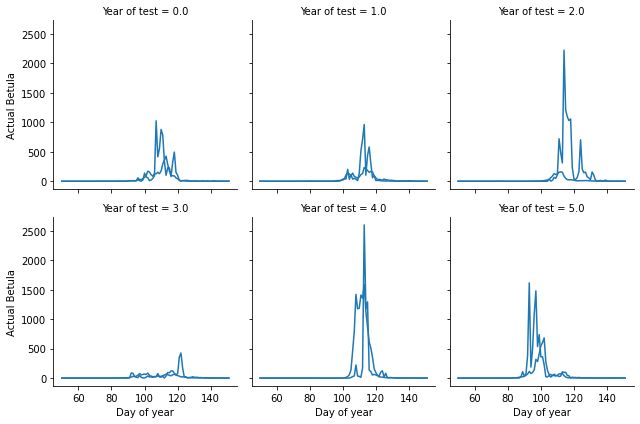

In [ ]:
plot = sns.FacetGrid(betula_test, col='Year of test', col_wrap=3, height=3)
plot.map(sns.lineplot, 'Day of year', 'Predicted Betula')
plot.map(sns.lineplot, 'Day of year', 'Actual Betula')
plt.show()

While the scores may seem disappointing, the predicted pollen concentration seems to be in the correct ballpark of the actual values. 
<br>
Hence we want to score the predicted pollen concentration in terms of symptoms (0=none, 1=mild, 2=severe) as defined on http://www.pollen.lu/index.php?qsPage=allergysteps. 

In [ ]:
def symptoms_level(pollen_concentration):
    if pollen_concentration < 10:
        return 0
    elif pollen_concentration < 50:
        return 1
    else:
        return 2

In [ ]:
betula_test['Predicted symptoms'] = betula_test['Predicted Betula'].apply(symptoms_level)
betula_test['Actual symptoms'] = betula_test['Actual Betula'].apply(symptoms_level)

In [ ]:
R2_symptoms = r2_score(betula_test['Actual symptoms'], betula_test['Predicted symptoms'])
print('The r2 score on the test set is ' + str(round(R2_symptoms,2)))

MSE_symptoms = mean_squared_error(betula_test['Actual symptoms'], betula_test['Predicted symptoms'])
print('The MSE on the test set is ' + str(round(MSE_symptoms,2)))

The r2 score on the test set is 0.56
The MSE on the test set is 0.25


This is quite good in view of our simple model. We also compare it with the score of a zero-value time series, for comparison purposes.

In [ ]:
betula_test['Nil symptoms'] = 0

In [ ]:
R2_nil = r2_score(betula_test['Actual symptoms'], betula_test['Nil symptoms'])
print('The r2 score on the test set is ' + str(round(R2_nil,2)))

MSE_nil = mean_squared_error(betula_test['Actual symptoms'], betula_test['Nil symptoms'])
print('The MSE on the test set is ' + str(round(MSE_nil,2)))

The r2 score on the test set is -0.37
The MSE on the test set is 0.77


# Conclusion and next steps

We concluded the data visualization, analysis and modeling successfully. In this mini-project we attempted to predict the pollen concentration for Betula (birch) solely based on the covariate mean temperature and obtained a rather satistfactory prediction (considering the simple model).
<br>
We note the following points that we could address if enough people show interest:
- More features: include other features in the model, such as past pollen concentration and past precipitation. Possibly other weather features as well (wind, etc). The global climate change since 1992 may also be of interest for modeling purposes.
- Challenge the parameters of the model, in particular the lag (window restricting the past temperature considered in the prediction) and the granularity of the predicted function n_intervals=12 (low granularity does not yield realistic prediction, but high granularity results in overfitting since there are only 24 observations in the training set). 
- Prediction intervals: it would be interesting to predict more than 1 day in the future, i.e. to assume in the model that $y(t)$ for $t_1 < t < t_2$ can be explained from $X(s)$ with $t_0 < s < t_1$.
- Dimensionality reduction: use functional principal component analysis to reduce the number of dimensions needed in the model, both for X (temperature) and y (pollen concentration). This can be done very elegantly using the method FPCA from the Scikit-fda package. 
- An elegant approach is performed in 'Forecasting Pollen Concentration by a Two-Step Functional Model' by Mariano J. Valderrama (https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1541-0420.2009.01293.x) where the residual noise between X and y is itself modeled. If you are interested to reproduce that approach here please do let me know.

Thanks for reading and please take some time to send me your feedback!